In [ ]:
# Author: Srijith Rajamohan based off the work by Robert Guthrie
# Source: 
# https://srijithr.gitlab.io/post/word2vec/

In [1]:
import os
from IPython.display import Image

pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

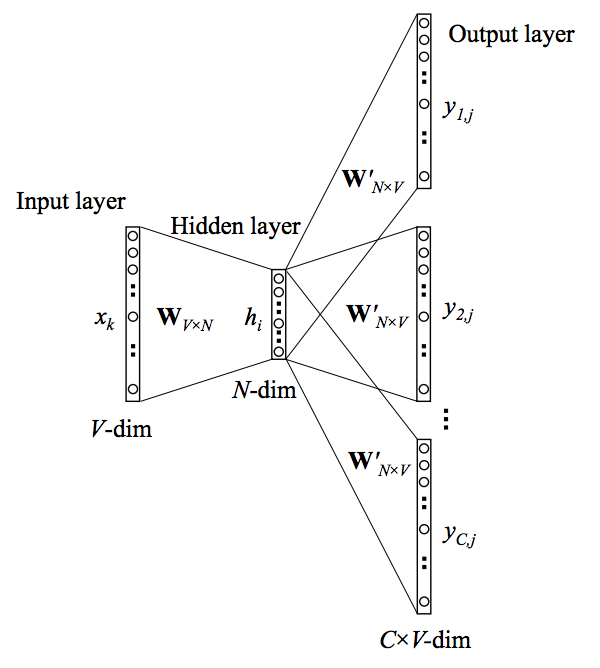

In [2]:
Image(filename=pth + '/SkipGramModel/images/Skip-gram.png')

In [3]:
import torch
import torch.tensor as Tensor 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

torch.manual_seed(1)

In [4]:
CONTEXT_SIZE = 3
EMBEDDING_DIM = 10

testSentence = """Empathy for the poor may not come easily to people who never experienced it. 
They may blame the victims and insist their predicament can be overcome through determination 
and hard work.
But they may not realize that extreme poverty can be psychologically and physically 
incapacitating — a perpetual cycle of bad diets, health care and education exacerbated 
by the shaming and self-fulfilling prophecies that define it in the public imagination.
Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human 
afflictions” and realized the power of empathy to help us understand it. It was neither an 
abstract problem nor political symbol, but something he endured growing up destitute in rural 
Kansas and having spent years documenting poverty throughout the world, including the United 
States.
That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published
 in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio 
 da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside 
 Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The
  Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition 
  co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and 
  the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and 
  Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by 
  Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
""".split()


# we should tokenize the input, but we will ignore that for now


# Building NGRAMS: build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
ngrams = []
for i in range(len(testSentence) - CONTEXT_SIZE):
    tup = [testSentence[j] for j in np.arange(i + 1, i + CONTEXT_SIZE + 1)]
    # skip-gram way of appending: 
    ngrams.append( (testSentence[i], tup) )
    # cbow# ngrams.append( (tup, testSentence[i + CONTEXT_SIZE]) )


# Creating vocabulary
vocabulary = set(testSentence)

# Creating word to index map: 
wordToIndex = {word : i for i, word in enumerate(vocabulary)}

In [22]:
def printKey(iWord, wordToIndexDict):
    """
    Prints the key (the word) corresponding to the given index in the given dictionary. 
    
    :param iWord: index of a word in the given dict
    :param wordToIndexDict: the dictionary 
    :return: key 
    """
    for key, index in wordToIndexDict.items():
        if(index == iWord):
            print(key)



def clusterEmbeddings(filename, numClusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=numClusters, random_state=  0).fit(X) # from sklearn
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X, center)

    for i in np.arange(0, distances.shape[1]):

        # get the index of the minimum distance in the ith row of the dist matrix
        iMinWord = np.argmin(distances[:, i])
        print(iMinWord)
        printKey(iWord=iMinWord, wordToIndexDict= wordToIndex)


def readData(filePath):
    tokenizer = RegexpTokenizer(r'\w+')
    data = urllib.request.urlopen(filePath)
    data = data.read().decode('utf8')
    tokenizedData = word_tokenize(data)

    # note: stopwords are from nltk
    stopWordsSet = set(stopwords.words('english'))
    stopWordsSet.update(['.',',',':',';','(',')','#','--','...','"'])
    cleanedWords = [word for word in tokenizedData if word not in stopWordsSet]

    return cleanedWords


In [6]:
class SkipGramModeler(nn.Module):
    
    def __init__(self, vocabSize: int, embeddingDim: int, contextSize: int):
        super(SkipGramModeler, self).__init__()

        # see docs: https://hyp.is/cv2pSAeqEeqIRHv7JAjgtA/pytorch.org/docs/stable/nn.html
        # num_embeddings = size of the dictionary embeddings
        # embedding_dim = the size of each embedding vector
        # Creating an embedding model that contains (vocabSize) tensors each of size (embeddingDim)
        self.embeddings = nn.Embedding(num_embeddings=vocabSize, 
                                       embedding_dim=embeddingDim,
                                       padding_idx=contextSize)

        # see nn.Linear docs
        # https://hyp.is/XEDPhgerEeqFhHssJYoa-w/pytorch.org/docs/stable/nn.html
        # note: in_features = size of each input sample
        # note: out_features = size of each output sample
        self.hiddenLayer = nn.Linear(in_features=embeddingDim, 
                                     out_features=128)
        
        self.outputLayer = nn.Linear(in_features=128, 
                                     out_features=contextSize * vocabSize)
        
        
    def forward(self, inputs: Tensor) -> Tensor:
        """
        
        :param inputs: 1-dim tensor 
        :return: 
        """
        # note: -1 implies the size inferred for that index from the size of data
        # is a tensor
        inputEmbeddings: Tensor = self.embeddings(inputs).view((1,-1))

        # output at hidden layer
        hiddenRELUResults: Tensor = F.relu(self.hiddenLayer(inputEmbeddings))
        # output at final layer
        outputResults: Tensor = self.outputLayer(hiddenRELUResults)

        logProbs: Tensor = F.log_softmax(input=outputResults, dim=1).view(CONTEXT_SIZE, -1)

        return logProbs



    def predict(self, inputStr: str, wordToIndexDict: dict) -> list:
        """
        
        :param inputStr: single word (targetword) from which we predict context list
        :return: 
        """
        contextIndices: Tensor = torch.tensor([wordToIndexDict[inputStr]], 
                                              dtype=torch.long)

        logProbs: Tensor = self.forward(contextIndices)

        # get index of maximum log probability from output layer
        #iMaxLogProbs: Tensor = torch.argmax(logProbs)

        # returns log probs sorted in descending order and
        # iSorted = indices of elements in the input tensor
        logProbsDecr, iSorted = logProbs.sort(descending=True)

        # same as logs.squeeze()[:3] (erasing first dimension)
        # since the tensor is [[...]]

        # getting sorted indices, the first one in each row of iSorted
        # (there are three rows in the iSorted, 2-dim tensor)
        numRows, numCols = iSorted.size()
        iFirstCol = 0
        indices = [iSorted[r][iFirstCol] for r in np.arange(0, numRows)]


        keyIndFilteredPairs: list = []

        for i in indices:
            
            keyIndFilteredPairs.append( [ (key, index)
                                       for key, index in wordToIndexDict.items()
                                       if index == i ]  )

        return keyIndFilteredPairs


    def freezeLayer(self, layer, skipgramModel: SkipGramModeler):
        """
        
        :param layer: 
        :return: 
        """
        for name, child in skipgramModel.named_children():
            print("\nLog | name = {}, child = {}".format(name, child))

            if(name == layer):

                # TODO: type of child?
                for names, params in child.named_parameters():
                    print("Log | names = {}, params = {}".format(names, params))
                    print("Log | params.size() = {}".format(params.size()))
                    params.requires_grad = False


    def printLayerParamers(self):
        for name, child in self.named_children():
            print("\nname = {}, child = {}".format(name, child))

            # TODO: type of child?
            for names, params in child.named_parameters():
                print("names = {}, params = {}".format(names, params))
                print("params.size() = {}".format(params.size()))


    def writeEmbeddingToFile(self, filename: str):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename, weights)
                    
            

In [17]:
# Trial : testing out the predict() inner workings

inputStr = "psychologically"

contextIndices: Tensor = torch.tensor([wordToIndex[inputStr]],
                                      dtype=torch.long)
print("contextIndices: ", contextIndices)
print("contextIndices dim: ", contextIndices.dim())
print("contextIndices size: ", contextIndices.size())




dummyModel = SkipGramModeler(vocabSize=len(vocabulary), embeddingDim=EMBEDDING_DIM,
                         contextSize=CONTEXT_SIZE)

logProbs: Tensor = dummyModel(contextIndices)


# returns log probs sorted in descending order and
# iSorted = indices of elements in the input tensor
logProbsDecr, iSorted = logProbs.sort(descending=True)
print("logProbsDecr dim : ", logProbsDecr.dim())
print("logProbsDecr shape : ", logProbsDecr.shape)
print("logProbsDecr squeezed: ", logProbsDecr.squeeze()[:, :5])
print("logProbsDecr squeezed dim :  ", logProbsDecr.squeeze().dim())
print("logProbsDecr squeezed shape: ", logProbsDecr.squeeze().shape)

print("\niSorted dim: ", iSorted.dim())
# note: in this case, squeezing is same as the original tensor; has no effect
print("iSorted: ", iSorted[:, :5])

logProbsDecr = logProbsDecr.squeeze()   # logProbsDecr[0][:3] 
iSorted = iSorted.squeeze()



# getting sorted indices, the first one in each row of iSorted
# (there are three rows in the iSorted, 2-dim tensor)
numRows, numCols = iSorted.size()
iFirstCol = 0
indices = [iSorted[r][iFirstCol] for r in np.arange(0, numRows)]

print("\nindices = ", indices)


# it length will be numRows of iSorted (numRows = 3)
# which equals CONTEXT_SIZE
keyIndFilteredPairs: list = [] 

for i in indices:

    keyIndFilteredPairs.append( [ (key, index)
                                  for key, index in wordToIndex.items()
                                  if index == i ]  )

print("\nlength of key,ind pairs: ", len(keyIndFilteredPairs))
print("keyIndFilteredPairs: ", keyIndFilteredPairs)

contextIndices:  tensor([111])
contextIndices dim:  1
contextIndices size:  torch.Size([1])
logProbsDecr dim :  2
logProbsDecr shape :  torch.Size([3, 195])
logProbsDecr squeezed:  tensor([[-5.7224, -5.7852, -5.8374, -5.8663, -5.8821],
        [-5.6024, -5.6381, -5.7106, -5.7565, -5.7699],
        [-5.6016, -5.6784, -5.8312, -5.8801, -5.9024]],
       grad_fn=<SliceBackward>)
logProbsDecr squeezed dim :   2
logProbsDecr squeezed shape:  torch.Size([3, 195])

iSorted dim:  2
iSorted:  tensor([[ 79,  67, 138,  58, 103],
        [ 91,  23, 181, 143, 121],
        [149, 137,  21, 102, 153]])

indices =  [tensor(79), tensor(91), tensor(149)]

length of key,ind pairs:  3
keyIndFilteredPairs:  [[('to', 79)], [('ramshackle', 91)], [('poor', 149)]]


In [19]:
# Training the model
learningRate = 0.001
NUM_EPOCHS = 550

losses = []
lossFunction = nn.NLLLoss()
skipGramModel = SkipGramModeler(vocabSize = len(vocabulary), 
                        embeddingDim=EMBEDDING_DIM, 
                        contextSize=CONTEXT_SIZE)
optimizer = optim.SGD(skipGramModel.parameters(), lr = learningRate)

# Freeze embedding layer (TODO: why???)
# model.freezeLayer("embeddings")

for epoch in range(NUM_EPOCHS):
    totalLoss = 0
    
    # note: skipgram predicts CONTEXT from single word
    # while CBOW predicts single TARGET word from CONTEXT list
    for contextWord, targetContext in ngrams: 
        
        # Step 1: Prepare the inputs to be passed to the model (means
        # turn the words into integer indices and wrap them in tensors)
        contextIndices: Tensor = torch.tensor([wordToIndex[contextWord]], 
                                              dtype=torch.long)
        
        # Step 2: 
        skipGramModel.zero_grad()
        
        # Step 3: run forward pass, getting log probs over the next words
        logProbs = skipGramModel(contextIndices)
        
        # Step 4: compute loss, where target word is wrapped in a tensor
        targetContextTensor: Tensor = torch.tensor([wordToIndex[w] for w in targetContext],
                                           dtype=torch.long)
        
        loss = lossFunction(logProbs, targetContextTensor)
        
        # Step 5: do backward pass and update gradient
        loss.backward()
        optimizer.step()
        
        totalLoss += loss.item()
        
    if(epoch % 50 == 0):
        print("Epoch = {}, Total loss = {}".format(epoch, totalLoss))
    
    losses.append(totalLoss)
        

Epoch = 0, Total loss = 1644.1534204483032


Epoch = 50, Total loss = 1486.1645240783691


Epoch = 100, Total loss = 1357.8808217048645


Epoch = 150, Total loss = 1225.4857697486877


Epoch = 200, Total loss = 1074.398155450821


Epoch = 250, Total loss = 915.9091166257858


Epoch = 300, Total loss = 772.6186662912369


Epoch = 350, Total loss = 659.3479555845261


Epoch = 400, Total loss = 577.9548418521881


Epoch = 450, Total loss = 522.5569497346878


Epoch = 500, Total loss = 485.1938408613205


In [23]:
skipGramModel.predict(inputStr = "psychologically", wordToIndexDict=wordToIndex)
skipGramModel.writeEmbeddingToFile("embeddings_skipgrams.txt")
clusterEmbeddings(filename="embeddings_skipgrams.txt", numClusters=5)

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings_skipgrams.txt'